## 02. Creating a Major Merger (MM) catalogue to study AGN incidence due to galaxy mergers

The notebook is divided into the following sections:
1. Loading data and defining input parameters
2. Creating a Major Merger sample (MM) and finding pairs
2. Studying merger fraction $f_{MM}$ as a function of redshift

**Script written by**: Soumya Shreeram <br>
**Project supervised by**: Johan Comparat <br>
**Date**: 30th March 2021

Import required packages

In [1]:
# scipy modules
from scipy.spatial import cKDTree
from scipy.interpolate import interp1d

# astropy modules
import astropy.units as u
import astropy.io.fits as fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM, z_at_value

import numpy as np

# system imports
import os
import sys
import importlib as ib

# plotting imports
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

Load the imported file(s) that contains all the functions used in this notebooks

In [2]:
%matplotlib inline
font = {'family' : 'serif',
        'weight' : 'medium',
        'size'   : 20}
matplotlib.rc('font', **font)

In [3]:
sys.path.append('imported_files/')
import Exploring_DM_Haloes as edh
import Agn_incidence_from_Major_Mergers as aimm
import plotting_aimm02 as pt

### 1. Defining input parameters

In [4]:
# look back into redshifts until...
redshift_limit = 1.5

# agn parameters
agn_FX_soft = 0

# galaxy parameters
galaxy_SMHMR_mass = 8.5 # unit: log 10, M_solar

# halo parameters
halo_mass_500c = 10**13.7 # solar masses
central_Mvir = 13.7 # unit: log 10, M_solar
cluster_params = [halo_mass_500c, central_Mvir]

# array deciding the cuts in the merger times and their linestyles
t_merger_cut_arr, l = [1, 2.5, 5], ['-', '--', ':']

# pixel number from the simulation file
pixel_no = '000000'

# number of cluster files for the chosen pixel_no
clu_files_no = 3

# define color palatte
pal = sns.hls_palette(10, h=.2).as_hex()

Define cosmology used in the notebook

In [5]:
cosmo = FlatLambdaCDM(H0=67.77*u.km/u.s/u.Mpc, Om0=0.307115)
h = 0.6777
L_box = 1000.0 / h

# interpolation function of z -> distance (depends on cosmology)
redshift_step = 0.0001
z_array = np.arange(0,redshift_limit+0.1, step=redshift_step)
f_z_to_comoving_dist = interp1d(z_array, cosmo.comoving_distance(z_array))

Parameters for creating the Major Merger catalogue.

In [19]:
# ratio of masses to call a merger a major merger
mass_ratio_for_MM = 4

# time since merger [Gyr]
time_since_merger = 5

### 2. Open files and get relevant data

In [20]:
hd_agn, hd_halo, hd_clu = edh.getHeaders(pixel_no, np.array(['agn', 'halo', 'cluster']), clu_files_no=clu_files_no)

Extracting positions and redshifts of the AGNs, galaxies, and halos

In [9]:
# agns
pos_z_AGN, scale_merger_AGN, conditions_agn = edh.getAgnData(hd_agn, agn_FX_soft, redshift_limit)    

# galaxies and halos
pos_z_gal, scale_merger_gal, conditions_gal = edh.getGalaxyData(hd_halo, galaxy_SMHMR_mass, redshift_limit)
pos_z_halo, scale_merger_halo, conditions_halo = edh.getGalaxyData(hd_halo, '', redshift_limit)

print("AGNs: %d, Galaxies: %d, Halos: %d"%(len(pos_z_AGN[0]), len(pos_z_gal[0]), len(pos_z_halo[0]) ))

AGNs: 632718, Galaxies: 2916774, Halos: 2916774


### 3.  Creating a Major Merger sample i.e. finding pairs

For a defined time since merger $\Delta t_{merger}$ criteria, the following function in the code block gets all objects in defined merger mass bins, $\Delta m_{merger}$.

In [21]:
hd_mm_halo_all, num_mass_mm_halo = aimm.majorMergerSampleForAllMassBins(hd_halo, conditions_halo, galaxy_SMHMR_mass, mass_ratio_for_MM, cosmo, time_since_merger)
hd_mm_agn_all, num_mass_mm_agn = aimm.majorMergerSampleForAllMassBins(hd_agn, conditions_agn, galaxy_SMHMR_mass, mass_ratio_for_MM, cosmo, time_since_merger)

It is constructive to know how many samples of DM halos and AGNs were found in each mass bin before counting for pairs. The following plot is for $1\ {\rm pixel}^2 = 53\ {\rm deg}^2$ on the sky.

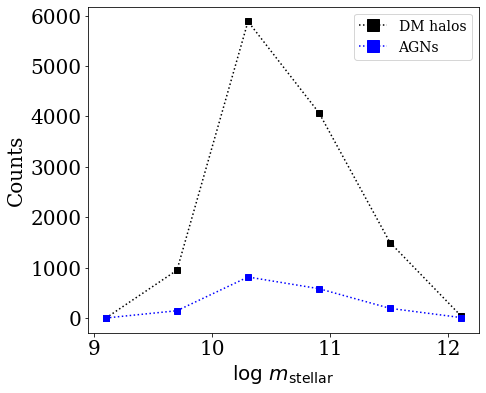

In [22]:
pt.plotCountsInMassBins(num_mass_mm_halo, num_mass_mm_agn)

Get pairs of DM halos and AGNs

In [29]:
num_pairs_halo_all, r_p, shell_volume = aimm.getNumberDensityOfPairs(hd_mm_halo_all)
num_pairs_agn_all, _, _ = aimm.getNumberDensityOfPairs(hd_mm_agn_all)

Plotting the distribution of the number density of pairs (normalized by the shell volume) as a function of the projected separation. The color scale shows the pairs found for a MM in different mass bins. As seen in the previous plot, we find none or few low mass ($10^{8.5-9.1} \ M_\odot$) and high mass ($10^{11.5-12.1} \ M_\odot$) major mergers in the chosen pixel.

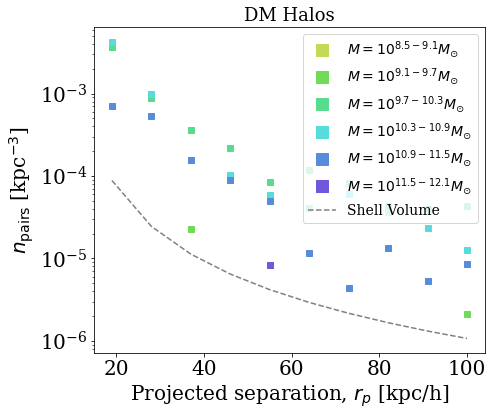

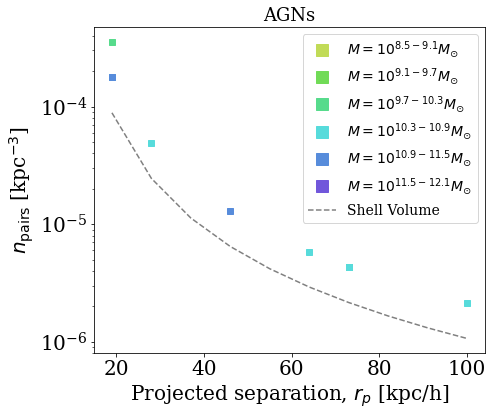

In [33]:
pt.plotNumberDensityVsRadius(num_pairs_halo_all, num_mass_mm_halo[1], r_p, shell_volume, pal, 'DM Halos')
pt.plotNumberDensityVsRadius(num_pairs_agn_all, num_mass_mm_agn[1], r_p, shell_volume, pal, 'AGNs') 